In [1]:
import os
import time
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

from embedding import GeminiEmbeddings
from document_processor import DocumentProcessor, ContextualHeaderProcessor
from vector_store import VectorstoreManager
from retrieval import StandardRetriever, ContextualHeaderRetriever
from llm_interface import get_openrouter_llm, StandardRAGChain, ContextualHeaderRAGChain
from evaluation import RAGEvaluator

# Check if environment variables are set
required_env_vars = ["GEMINI_API_KEY", "PINECONE_API_KEY", "OPENROUTER_API_KEY"]
missing_vars = [var for var in required_env_vars if not os.getenv(var)]

if missing_vars:
    print(f"Missing environment variables: {', '.join(missing_vars)}")
    print("Please set these variables in your .env file.")
else:
    print("All required environment variables are set.")

All required environment variables are set.


In [2]:
# Configuration
DOCS_DIR = "books"  # Path to the documents directory
CHUNK_SIZE = 2000      # Size of text chunks
CHUNK_OVERLAP = 200    # Overlap between chunks
REBUILD_INDEX = False   # Whether to rebuild the vector store index

# Initialize components

In [3]:
# Initialize the embedding model
print("Initializing the embedding model ...")
embeddings = GeminiEmbeddings()

# Initialize the LLM
print("Initializing the LLM ...")
llm = get_openrouter_llm()

print("Initializing the vector store")
vectorstore_manager = VectorstoreManager(embeddings)

Initializing the embedding model ...
Initializing the LLM ...
Initializing the vector store


# Process Documents and Create vector store

In [4]:
if REBUILD_INDEX:
    print("Rebuilding index from documents ...")
    doc_processor = DocumentProcessor(DOCS_DIR,
                                      chunk_size=CHUNK_SIZE,
                                      chunk_overlap=CHUNK_OVERLAP)
    standard_docs = doc_processor.process_documents()
    print(f"Processed {len(standard_docs)} document chunks for standard RAG")

    # Display a sample document chunk
    if standard_docs:
        print("\nSample standard document chunk:")
        print(f"Source: {standard_docs[0].metadata.get("source", "unknown")}")
        print(f"Content (first 300 chars): {standard_docs[0].page_content[:300]}...")

    # Contextual Header document processing
    contextual_doc_processor = DocumentProcessor(
        llm = LLM,
        chunk_size = CHUNK_SIZE,
        chunk_overlap = CHUNK_OVERLAP,
        docs_dir = DOCS_DIR
    )
    contextual_docs = contextual_doc_processor.process_documents()
    print(f"Processed {len(contextual_docs)} document chunks for contextual RAG")

    # Display a sample contextual document chunk
    if contextual_docs:
        print("\nSample contextual document chunk:")
        print(f"Source: {contextual_docs[0].metadata.get("source", "unknown")}")
        print(f"Content (first 300 chars): {contextual_docs[0].page_content[:300]}...")

    # Add documents to the vector store
    # Clear any existing vector store
    print("Clearing any existing vector store")
    vectorstore_manager.clear_all()

    # Add documents to vector store
    print("Adding documents to standard RAG vector store...")
    vectorstore_manager.add_documents(standard_docs)
    # Add contextual documents to vector store
    print("Adding documents to contextual RAG vector store...")
    vectorstore_manager.add_documents(contextual_docs)

    

# Initialize Retrievers and RAG Chains

In [5]:
# Get vector stores
standard_vector_store = vectorstore_manager.get_standard_vector_store()
contextual_vector_store = vectorstore_manager.get_contextual_vector_store()

# Initialize retrievers
standard_retriever = StandardRetriever(standard_vector_store)
contextual_retriever = ContextualHeaderRetriever(contextual_vector_store)

# Initialize RAG chains
standard_rag = StandardRAGChain(llm, standard_retriever)
contextual_rag = ContextualHeaderRAGChain(llm, contextual_retriever)

# Initialize evaluator
evaluator = RAGEvaluator(embeddings)

# Query both RAGs

In [6]:
def test_query(query):
    print(f"\nquery: {query}")
    print("\n Processing...")

    # Measure standard RAG performance
    print("Running standard RAG...")
    standard_start = time.time()
    standard_response = standard_rag.invoke(query)
    standard_time = time.time() - standard_start

    # Measure contextual header RAG performance
    print("Running contextual header RAG...")
    contextual_start = time.time()
    contextual_response = contextual_rag.invoke(query)
    contextual_time = time.time() - contextual_start

    # Print results
    print("\n=== Standard RAG ===")
    print(f"Time: {standard_time:.2f}s")
    print(f"Response: {standard_response}")
    
    print("\n=== Contextual Header RAG ===")
    print(f"Time: {contextual_time:.2f}s")
    print(f"Response: {contextual_response}")
    
    # Return the responses and times for further analysis
    return {
        "standard": {"response": standard_response, "time": standard_time},
        "contextual": {"response": contextual_response, "time": contextual_time}
    }

In [7]:
import time
test_query("What are the key principles in the Declaration of Independence?")


query: What are the key principles in the Declaration of Independence?

 Processing...
Running standard RAG...
Running contextual header RAG...

=== Standard RAG ===
Time: 10.56s
Response: The key principles in the Declaration of Independence are:

1. **All men are created equal**: The document asserts that all individuals are born with inherent rights and dignity, and are equal in the eyes of the law.
2. **Life, Liberty, and the pursuit of Happiness**: The document outlines the fundamental rights that governments are instituted to protect, including the right to life, liberty, and the pursuit of happiness.
3. **Governments derive their power from the consent of the governed**: The document states that governments are derived from the people, and that the people have the right to alter or abolish them if they become destructive of these rights.
4. **The right to alter or abolish a government is a fundamental right**: The document asserts that the people have the right to change their 

{'standard': {'response': "The key principles in the Declaration of Independence are:\n\n1. **All men are created equal**: The document asserts that all individuals are born with inherent rights and dignity, and are equal in the eyes of the law.\n2. **Life, Liberty, and the pursuit of Happiness**: The document outlines the fundamental rights that governments are instituted to protect, including the right to life, liberty, and the pursuit of happiness.\n3. **Governments derive their power from the consent of the governed**: The document states that governments are derived from the people, and that the people have the right to alter or abolish them if they become destructive of these rights.\n4. **The right to alter or abolish a government is a fundamental right**: The document asserts that the people have the right to change their government if it becomes tyrannical or abusive.\n5. **The purpose of government is to protect the rights of its citizens**: The document emphasizes that the p

In [8]:
test_query("Who wrote the Declaration of Independence?")


query: Who wrote the Declaration of Independence?

 Processing...
Running standard RAG...
Running contextual header RAG...

=== Standard RAG ===
Time: 1.78s
Response: The Declaration of Independence was written by Thomas Jefferson.

=== Contextual Header RAG ===
Time: 5.47s
Response: Based on the context provided, it appears that the Declaration of Independence was written by a group of individuals, likely representatives of the 13 American colonies, who were dissatisfied with British rule and decided to declare their independence.

The text does not explicitly mention who wrote the Declaration of Independence, but it is clear that it was a collective effort by the representatives of the colonies. The language used, such as "we, therefore, the Representatives of the United States of America," suggests a collaborative effort.

If you're looking for information on who wrote the Declaration of Independence, I would suggest checking the following sources:

* The official website of the Na

{'standard': {'response': 'The Declaration of Independence was written by Thomas Jefferson.',
  'time': 1.776414394378662},
 'contextual': {'response': 'Based on the context provided, it appears that the Declaration of Independence was written by a group of individuals, likely representatives of the 13 American colonies, who were dissatisfied with British rule and decided to declare their independence.\n\nThe text does not explicitly mention who wrote the Declaration of Independence, but it is clear that it was a collective effort by the representatives of the colonies. The language used, such as "we, therefore, the Representatives of the United States of America," suggests a collaborative effort.\n\nIf you\'re looking for information on who wrote the Declaration of Independence, I would suggest checking the following sources:\n\n* The official website of the National Archives and Records Administration (NARA) in the United States, which provides information on the history of the Decla

In [9]:
def examine_retrieved_docs(query):
    """Examine the documents retrieved by both approaches for a query."""
    print(f"\nQuery: {query}")
    
    # Get documents from standard retriever
    print("Retrieving documents from standard retriever...")
    standard_docs = standard_retriever.get_relevant_documents(query)
    
    # Get documents from contextual header retriever
    print("Retrieving documents from contextual header retriever...")
    contextual_docs = contextual_retriever.get_relevant_documents(query)
    
    # Print standard retriever results
    print("\n=== Standard Retriever Results ===")
    print(f"Retrieved {len(standard_docs)} documents")
    
    for i, doc in enumerate(standard_docs):
        print(f"\nDocument {i+1}:")
        print(f"Source: {doc.metadata.get('source', 'Unknown')}")
        print(f"Score: {doc.metadata.get('score', 'N/A')}")
        print(f"Content (first 200 chars): {doc.page_content[:200]}...")
    
    # Print contextual header retriever results
    print("\n=== Contextual Header Retriever Results ===")
    print(f"Retrieved {len(contextual_docs)} documents")
    
    for i, doc in enumerate(contextual_docs):
        print(f"\nDocument {i+1}:")
        print(f"Source: {doc.metadata.get('source', 'Unknown')}")
        print(f"Score: {doc.metadata.get('score', 'N/A')}")
        print(f"Header: {doc.metadata.get('header', 'No header')}")
        print(f"Content (first 200 chars): {doc.page_content[:200]}...")

In [10]:
%run ipv4_fix.py
# Examine retrieved documents for a query
examine_retrieved_docs("What rights are mentioned in the Declaration of Independence?")

IPv6 has been disabled for this application. It will only use IPv4 connections.

Query: What rights are mentioned in the Declaration of Independence?
Retrieving documents from standard retriever...


/tmp/ipykernel_6333/3647580429.py:7: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  standard_docs = standard_retriever.get_relevant_documents(query)


Retrieving documents from contextual header retriever...

=== Standard Retriever Results ===
Retrieved 4 documents

Document 1:
Source: ../books/declaration_of_independence_of_the_united_states.txt
Score: 0.68735373
Content (first 200 chars): We hold these truths to be self-evident, that all men are created equal,
that they are endowed by their Creator with certain unalienable Rights,
that among these are Life, Liberty, and the pursuit of ...

Document 2:
Source: ../books/declaration_of_independence_of_the_united_states.txt
Score: 0.68735373
Content (first 200 chars): We hold these truths to be self-evident, that all men are created equal,
that they are endowed by their Creator with certain unalienable Rights,
that among these are Life, Liberty, and the pursuit of ...

Document 3:
Source: ../books/declaration_of_independence_of_the_united_states.txt
Score: 0.670296192
Content (first 200 chars): The Declaration of Independence of The United States of America




IN CONGRESS, July 4, 177

In [11]:
# Sample queries for benchmarking
benchmark_queries = [
    "What are the key principles in the Declaration of Independence?",
    "Who wrote the Declaration of Independence?",
    "What grievances were listed in the Declaration of Independence?",
    "What rights are mentioned in the Declaration of Independence?",
    "When was the Declaration of Independence signed?",
]

# Run evaluation - progress bars will show the status of each query
evaluator.run_evaluation(benchmark_queries, standard_rag, contextual_rag)

# Get summary metrics
summary = evaluator.get_summary_metrics()

# Print summary
print("\n=== Evaluation Results ===")
print("\nStandard RAG:")
for metric, value in summary["standard"].items():
    print(f"  {metric}: {value:.4f}")

print("\nContextual Header RAG:")
for metric, value in summary["contextual"].items():
    print(f"  {metric}: {value:.4f}")

Running evaluation on 5 queries ...


Evaluating queries:   0%|          | 0/5 [00:00<?, ?it/s]


=== Evaluation Results ===

Standard RAG:
  avg_query_time: 4.0662
  avg_semantic_relevance: 0.6598

Contextual Header RAG:
  avg_query_time: 2.7585
  avg_semantic_relevance: 0.6781


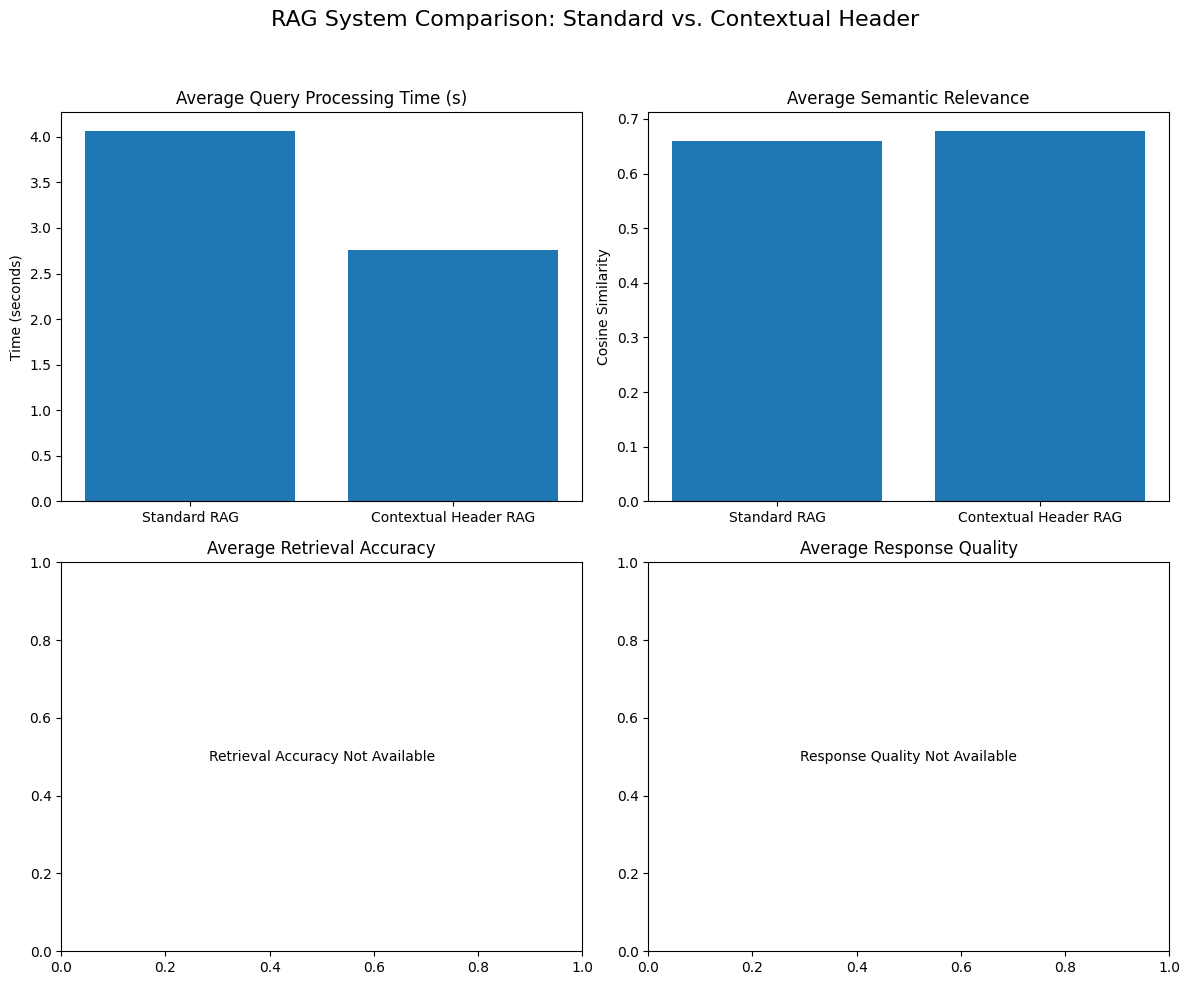

In [12]:
# Visualize results
evaluator.visualize_results()

In [14]:
from tqdm.notebook import tqdm
# Analyze detailed results for each query
print("Analyzing detailed results for each query...")
for query, standard_results in tqdm(evaluator.results["standard"].items(), desc="Analyzing queries"):
    contextual_results = evaluator.results["contextual"][query]
    
    print(f"\n=== Query: {query} ===\n")
    
    # Print metrics comparison
    print("Metrics Comparison:")
    print(f"  Query Time: Standard={standard_results['query_time']:.4f}s, Contextual={contextual_results['query_time']:.4f}s")
    print(f"  Semantic Relevance: Standard={standard_results['semantic_relevance']:.4f}, Contextual={contextual_results['semantic_relevance']:.4f}")
    
    if 'retrieval_accuracy' in standard_results and 'retrieval_accuracy' in contextual_results:
        print(f"  Retrieval Accuracy: Standard={standard_results['retrieval_accuracy']:.4f}, Contextual={contextual_results['retrieval_accuracy']:.4f}")
    
    if 'response_quality' in standard_results and 'response_quality' in contextual_results:
        print(f"  Response Quality: Standard={standard_results['response_quality']:.4f}, Contextual={contextual_results['response_quality']:.4f}")
    
    # Print responses
    print("\nStandard RAG Response:")
    print(standard_results['response'][:500] + "..." if len(standard_results['response']) > 500 else standard_results['response'])
    
    print("\nContextual Header RAG Response:")
    print(contextual_results['response'][:500] + "..." if len(contextual_results['response']) > 500 else contextual_results['response'])

Analyzing detailed results for each query...


Analyzing queries:   0%|          | 0/5 [00:00<?, ?it/s]


=== Query: What are the key principles in the Declaration of Independence? ===

Metrics Comparison:
  Query Time: Standard=4.4716s, Contextual=4.7737s
  Semantic Relevance: Standard=0.6771, Contextual=0.7130

Standard RAG Response:
The key principles in the Declaration of Independence are:

1. **All men are created equal**: The document asserts that all individuals are born with inherent rights and dignity, and that these rights are unalienable, meaning they cannot be taken away by any government.
2. **Life, Liberty, and the pursuit of Happiness**: The document outlines the fundamental rights that governments are instituted to protect, including the right to life, liberty, and the pursuit of happiness.
3. **Governments der...

Contextual Header RAG Response:
The key principles in the Declaration of Independence are:

1. **All men are created equal**: This is stated in the first paragraph, emphasizing that all individuals are born with certain unalienable rights, including life, libert

In [ ]:
custom_query = "What is the significance of the phrase 'all men are created equal' in the Declaration of Independence?"
test_query(custom_query)


query: What is the significance of the phrase 'all men are created equal' in the Declaration of Independence?

 Processing...
Running standard RAG...
Running contextual header RAG...

=== Standard RAG ===
Time: 5.94s
Response: The phrase "all men are created equal" is a fundamental concept in the Declaration of Independence, and it is a crucial part of the document's significance.

In the context of the Declaration of Independence, "all men are created equal" means that every individual human being is born with the same fundamental rights and dignity, regardless of their social status, race, or background. This phrase is a statement of the inherent equality and worth of all people, and it is a key principle of the document's argument for the colonies' right to independence.

The phrase is also closely tied to the idea of the "unalienable Rights" listed in the document, which includes "Life, Liberty, and the pursuit of Happiness." These rights are not just privileges granted by the gov

{'standard': {'response': 'The phrase "all men are created equal" is a fundamental concept in the Declaration of Independence, and it is a crucial part of the document\'s significance.\n\nIn the context of the Declaration of Independence, "all men are created equal" means that every individual human being is born with the same fundamental rights and dignity, regardless of their social status, race, or background. This phrase is a statement of the inherent equality and worth of all people, and it is a key principle of the document\'s argument for the colonies\' right to independence.\n\nThe phrase is also closely tied to the idea of the "unalienable Rights" listed in the document, which includes "Life, Liberty, and the pursuit of Happiness." These rights are not just privileges granted by the government, but rather inherent to all human beings, and they are equal and inalienable.\n\nThe significance of this phrase can be understood by considering the historical context of the time. The 